In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt

In [2]:
def unconditionalProbability(Ptrans):
   """Compute the unconditional probability for the states of a
   Markov chain."""

   m = Ptrans.shape[0]

   P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))

   I = np.eye(m)
   U = np.ones((m, m))
   u = np.ones(m)

   return np.linalg.solve((I - P + U).T, u)



In [3]:
data = np.loadtxt('test_data.txt',
                 dtype=np.dtype([('state', np.uint8),
                                 ('emission', np.float)]),
                 delimiter=',',
                 skiprows=1)

data['state'] = data['state']-1
data['state']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0,

In [4]:
# Two state model for simplicity.
N_states = 2
N_chain = len(data)

# Transition probability stochastic
theta = np.ones(N_states) + 1.

In [14]:
class HMMStates(pm.Discrete):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P1 : tensor
        probability to remain in state 1
    P2 : tensor
        probability to move from state 2 to state 1
    
    """

    def __init__(self, PA=None, P1=None, P2=None,
                 *args, **kwargs):
        super(HMMStates, self).__init__(*args, **kwargs)
        self.PA = PA
        self.P1 = P1
        self.P2 = P2
        self.mean = 0.

    def logp(self, x):
        PA = self.PA
        P1 = self.P1
        P2 = self.P2
        
        # now we need to create an array with probabilities
        # so that for x=A: PA=P1, PB=(1-P1)
        # and for x=B: PA=P2, PB=(1-P2)
        # for more than two states we may use tt.choose()
        #length = x.shape[0]
        #P1T = tt.tile(P1,(length-1,1)).T
        #P2T = tt.tile(P2,(length-1,1)).T
        
        #P = tt.switch(x[:-1],P1T,P2T).T
        choice = tt.stack((P1,P2))
        P = choice[x[:-1]]
        
        x_i = x[1:]
        
        ou_like = pm.Categorical.dist(P).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)


In [15]:
with pm.Model() as model:
    # 2 state model
    # P1 is probablility to stay in state 1
    # P2 is probability to move from state 2 to state 1
    P1 = pm.Dirichlet('P1', a=theta)
    P2 = pm.Dirichlet('P2', a=theta)
    
    PA = pm.Deterministic('PA',P2/(P2+1-P1))
    
    states = HMMStates('states',PA,P1,P2, observed=data['state'])
    
    start = pm.find_MAP()
    
    trace = pm.sample(5000, start=start)
    

Optimization terminated successfully.
         Current function value: 396.915599
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -399.19: 100%|██████████| 200000/200000 [02:20<00:00, 1426.74it/s]
Finished [100%]: Average ELBO = -399.19
100%|██████████| 5000/5000 [00:38<00:00, 130.25it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e38cdd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d9aec88>]], dtype=object)

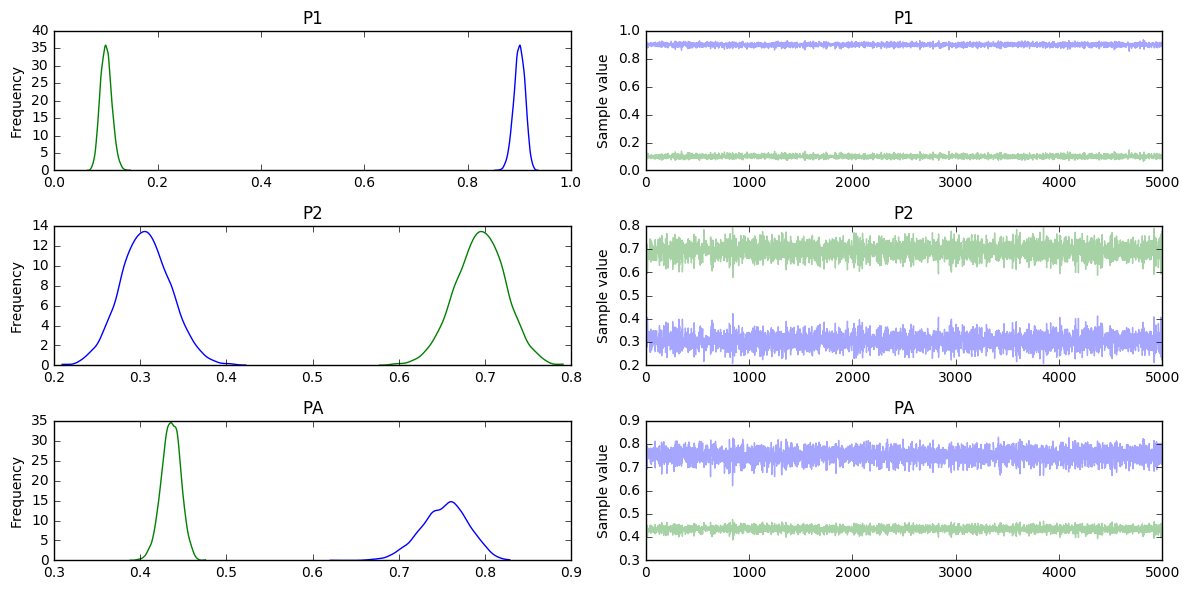

In [16]:
%matplotlib inline
pm.traceplot(trace)